In [1]:
from tqdm.notebook import tqdm
from tqdm import tqdm as tqdm_t

import numpy as onp
import matplotlib.pyplot as plt # visualization

import jax
from jax import ops
import jax.numpy as np
from jax import jit, grad, value_and_grad, random, device_put
from jax import lax
from jax.random import split
from jax.tree_util import tree_multimap
from jax import vmap
from jax.tree_util import Partial as partial

from jax.experimental import optix
from jax.experimental import optimizers
from jax.experimental import stax # neural network library
from jax.experimental.stax import Conv, Dense, MaxPool, Relu, Flatten, LogSoftmax # neural network layers

In [2]:
rng = random.PRNGKey(0)
rng

DeviceArray([0, 0], dtype=uint32)

In [3]:
def sample_tasks(rng, outer_batch_size, inner_batch_size):
    # Select amplitude and phase for the task
    rng, rngA, rngP = split(rng, 3)
    As = random.uniform(rngA, shape=(outer_batch_size,), minval=0.1, maxval=5.0)
    phases = random.uniform(rngP, shape=(outer_batch_size,), minval=0, maxval=np.pi)
    
    def get_batch(rng):
        xs = np.empty((outer_batch_size, inner_batch_size, 1))
        ys = np.empty((outer_batch_size, inner_batch_size, 1))
        rngs = split(rng, outer_batch_size)
        for i, (A, phase, rng) in enumerate(zip(As, phases, rngs)):
            x = random.uniform(rng, shape=(inner_batch_size, 1), minval=-5., maxval=5., )
            y = A * np.sin(x + phase)
            xs = ops.index_update(xs, i, x)
            ys = ops.index_update(ys, i, y)
        return xs, ys
    rng2, rng3 = split(rng, 2)
    x1, y1 = get_batch(rng2)
    x2, y2 = get_batch(rng3)
    return x1, y1, x2, y2, As, phases

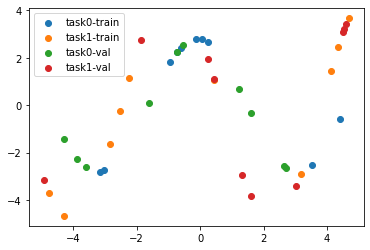

In [4]:
rng, rng_sample = split(rng, 2)
x1, y1, x2, y2, As, phases = sample_tasks(rng, 2, 10)

for i in range(x1.shape[0]):
    plt.scatter(x1[i], y1[i], label='task{}-train'.format(i))
for i in range(x1.shape[0]):
    plt.scatter(x2[i], y2[i], label='task{}-val'.format(i))
plt.legend()

In [5]:
net_init, net_apply = stax.serial(
    Dense(40), Relu,
    Dense(40), Relu,
    Dense(1),
)

def make_net(rng, in_shape=(-1, 1)):
    rng, rng_net = split(rng, 2)
    return net_init(rng_net, in_shape)

def mse_loss(preds, targets):
    return np.mean((preds - targets) ** 2)

In [6]:
xrange_inputs = np.linspace(-5, 5, 100).reshape((100, 1)) # (k, 1)
targets = np.sin(xrange_inputs)

# Train vanilla SGD

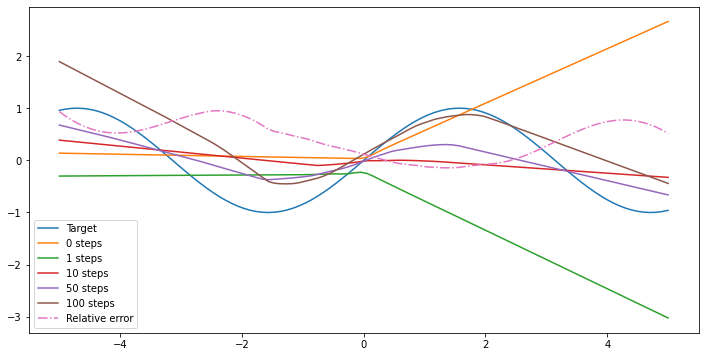

In [7]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(xrange_inputs, targets, label="Target")

out_shape, net_params = make_net(rng)
opt_init, opt_update, get_params = optimizers.sgd(1e-1)
opt_state = opt_init(net_params)

@jit
def loss_fn(params, inputs, targets):
    return mse_loss(net_apply(params, inputs), targets)

ax.plot(xrange_inputs, net_apply(net_params, xrange_inputs), label="0 steps")
plot_steps = [1, 10, 50, 100]
for i in range(1, 101):
    loss, grads = value_and_grad(loss_fn)(net_params, xrange_inputs, targets)
    opt_state = opt_update(i - 1, grads, opt_state)
    net_params = get_params(opt_state)
    
    if i in plot_steps:
        preds = net_apply(net_params, xrange_inputs)
        ax.plot(xrange_inputs, preds, label="%d steps" % i)

pointwise_loss = (preds - targets)
ax.plot(xrange_inputs, pointwise_loss, linestyle='-.', label="Relative error")
ax.legend()

In [8]:
def sgd_k_steps(params, loss_fn, x, y, k, opt_state, opt_get_updates_fn):
    loss_history = np.zeros(k + 1)
    for i in range(k):
        loss, grads = value_and_grad(loss_fn)(params, x, y)
        updates, opt_state = opt_get_updates_fn(grads, opt_state, params)
        params = optix.apply_updates(params, updates)
        loss_history = ops.index_update(loss_history, i, loss)

    final_loss = loss_fn(params, x, y)
    loss_history = ops.index_update(loss_history, k + 1, final_loss)
    
    return params, opt_state, loss_history

def outer_loss_fn(params, inner_loss_fn, x_in, y_in, x_out, y_out, k, inner_opt):
    inner_opt_state = inner_opt.init(params)
    params, _, inner_loss = sgd_k_steps(params, inner_loss_fn, x_in, y_in, k, inner_opt_state, inner_opt.update)
    return mse_loss(net_apply(params, x_out), y_out), inner_loss

def batch_outer_loss(params, inner_loss_fn, x_in, y_in, x_out, y_out, k, inner_opt):
    outer_losses, inner_losses = vmap(
        partial(outer_loss_fn, params, inner_loss_fn, k=k, inner_opt=inner_opt)
    )(x_in, y_in, x_out, y_out)
    return outer_losses.mean(), inner_losses.mean(0)

In [9]:
jit_batch_outer_loss = jit(batch_outer_loss, static_argnums=(1, 6, 7))
jit_sample_tasks = jit(sample_tasks, static_argnums=(1, 2))

In [42]:
inner_opt = optix.sgd(1e-3)
outer_opt_init, outer_opt_update, outer_get_params = optimizers.adam(step_size=1e-3)
out_shape, net_params = make_net(rng)
outer_opt_state = outer_opt_init(net_params)

num_inner_steps = 1
num_tasks = 25
num_samples = 10

@jit
def inner_loss_fn(params, inputs, targets):
    return mse_loss(net_apply(params, inputs), targets)

def step(rng_task, i, opt_state):
    x1, y1, x2, y2, _, _ = jit_sample_tasks(rng_task, num_tasks, num_samples)
    p = outer_get_params(opt_state)
    (outer_loss, inner_loss), outer_grads = value_and_grad(
        jit_batch_outer_loss, has_aux=True,
    )(p, inner_loss_fn, x1, y1, x2, y2, num_inner_steps, inner_opt)
    opt_state = outer_opt_update(i, outer_grads, opt_state)
    net_params = outer_get_params(opt_state)
    
    return opt_state, outer_loss, inner_loss

device = "gpu"
backend = jax.devices(device)[0]
step = jit(step, backend=device)

num_outer_steps = 70000
pbar = tqdm(range(num_outer_steps))
# np_batched_maml_loss = []
np_batched_maml_loss = device_put(np.zeros(num_outer_steps), backend)
for i in pbar:
    rng, rng_task = split(rng, 2)
    outer_opt_state, outer_loss, inner_loss = step(rng_task, i, outer_opt_state)

    if (i % 500) == 0:
        pbar.set_postfix(
            outer_loss=outer_loss, inner_loss=inner_loss[-1],
            refresh=True,
        )
    # np_batched_maml_loss.append(outer_loss)
    np_batched_maml_loss = ops.index_update(np_batched_maml_loss, i, outer_loss)
    
multi_batch_params = outer_get_params(outer_opt_state)

MSE 5-shot 1 steps
0.6037637
MSE 5-shot 5 steps
0.474091
MSE 5-shot 10 steps
0.475591


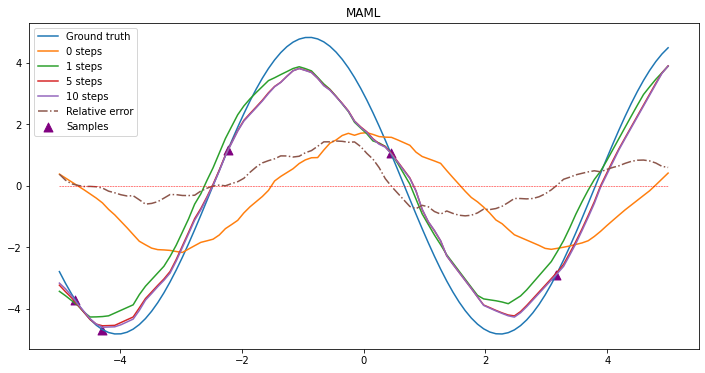

In [45]:

num_samples = 5

np_batched_maml_lfig, ax = plt.subplots(figsize=(12, 6))
ax.plot(xrange_inputs, np.sin(xrange_inputs + phases[1]) * As[1], label="Ground truth")
ax.scatter(x1[1, :5], y1[1, :5], marker="^", label="Samples", color="purple", s=80)

new_params = multi_batch_params
ax.plot(xrange_inputs, net_apply(new_params, xrange_inputs), label="0 steps")
inner_opt = optix.sgd(1e-3)
inner_opt_state = inner_opt.init(new_params)
for i in range(0, 10):
    new_params, inner_opt_state, loss = sgd_k_steps(
        new_params, inner_loss_fn, x1[1, :num_samples], y1[1, :num_samples], 1, inner_opt_state, inner_opt.update,
        )

    # (new_params, inner_opt_state), loss = jittable_k_updates(
    #     new_params, x1[1, :5], y1[1, :5], k=1, opt_state=inner_opt_state, opt_update=inner_opt.update,
    # )

    if (i + 1) in [1, 5, 10]:
        preds = net_apply(new_params, xrange_inputs)
        ax.plot(xrange_inputs, preds, label="%d steps" % (i + 1))

        pointwise_loss = (np.sin(xrange_inputs + phases[1]) * As[1] - preds)
        print("MSE 5-shot %d steps" % (i + 1))
        print((pointwise_loss ** 2).mean())
        
ax.plot(xrange_inputs, pointwise_loss, linestyle='-.', label="Relative error")
ax.plot(xrange_inputs, np.zeros(len(xrange_inputs)), color="red", linestyle='--', linewidth=0.5)


ax.legend()
ax.set_title("MAML");

In [59]:
class SineSampler:
    def __init__(self, rng, tasks, capacity):
        self.tasks = tasks
        self.capacity = capacity
        self.task_iterators = []

        rng_amplitude, rng_phase, rng_decay, rng_frequency = split(rng, 4)

        self.iterators = {
            "id": tasks,
            "amplitude": random.uniform(rng_amplitude, (len(tasks),), minval=0.1, maxval=5.0),
            "phase": random.uniform(rng_amplitude, (len(tasks),), minval=0.0, maxval=1.0) * np.pi,
            "decay": random.uniform(rng_decay, (len(tasks),), minval=0.0, maxval=1.0) * 0.4,
            "frequency": random.uniform(rng_frequency, (len(tasks),), minval=0.0, maxval=1.0) * 2 + 1.0,
        }

    def sample_batch(self, rng, task, task_map_id, num_samples=10):
        rng, rng_samples = split(rng, 2)
        x_samples = random.uniform(rng_samples, (num_samples,), minval=-5.0, maxval=5.0)
        x = np.zeros((num_samples, self.capacity))
        x = ops.index_update(x, ops.index[:, self.capacity - 1], x_samples)
        # assert task_map_id < self.capacity
        # assert lax.lt(task_map_id, self.capacity)
        x = ops.index_update(x, ops.index[:, task_map_id], 1)

        targets = np.zeros((num_samples, 2))
        amplitude = self.iterators["amplitude"][task]
        phase = self.iterators["phase"][task]
        targets = ops.index_update(targets, ops.index[:, 0], amplitude * np.sin(x_samples + phase))

        return x, targets

In [26]:
def construct_sets(rng, tasks, sampler, num_steps, num_samples, shuffle_ids=True):
    rng_shuffle, rng_sample = split(rng, 2)

    x_spt, y_spt = [], []
    x_qry, y_qry = [], []

    id_map = np.arange(0, sampler.capacity - 1)
    if shuffle_ids:
        id_map = random.permutation(rng_shuffle, id_map)
    
    for task_id in tasks:
        rng_sample_spt, rng_sample_qry = split(rng_sample, 2)
        task_mapped_id = id_map[task_id]
        x, y = sampler.sample_batch(rng_sample_spt, task_id, task_mapped_id, num_samples * num_steps)
        x_spt.append(x), y_spt.append(y)

        x, y = sampler.sample_batch(rng_sample_spt, task_id, task_mapped_id, num_samples)
        x_qry.append(x), y_qry.append(y)

    x_qry = np.concatenate(x_qry)
    y_qry = np.concatenate(y_qry)

    x_spt = np.stack(x_spt)
    y_spt = np.stack(y_spt)

    return x_spt, y_spt, x_qry, y_qry

In [27]:
x_spt, y_spt, x_qry, y_qry = construct_sets(rng, [1, 2, 3], sine_sampler, 10, 10)

In [30]:
x_spt.shape, y_spt.shape, x_qry.shape, y_qry.shape

((3, 100, 41), (3, 100, 2), (30, 41), (30, 2))

In [62]:
capacity = 40
hidden_dim = 300
num_rln_layers = 6
num_pln_layers = 2

rln_init, rln_apply = stax.serial(
    *([stax.Dense(hidden_dim), stax.Relu] * num_rln_layers),
)

pln_init, pln_apply = stax.serial(
    *([stax.Dense(hidden_dim), stax.Relu] * num_pln_layers),
    stax.Dense(2),
)

def cl_net_init(rng, input_shape):
    rng_rln, rng_pln = split(rng, 2)
    rln_out_shape, rln_params = rln_init(rng_rln, input_shape)
    pln_out_shape, pln_params = pln_init(rng_pln, rln_out_shape)
    return rln_params, pln_params

def cl_net_apply(rln_params, pln_params, inputs):
    return pln_apply(pln_params, rln_apply(rln_params, inputs))

In [73]:
def cl_net_mse_loss(rln_params, pln_params, inputs, targets):
    return mse_loss(cl_net_apply(rln_params, pln_params, inputs), targets)

def inner_trajectory_update(rln_params, pln_params, x_spt, y_spt, opt_state, opt_update):
    for _x, _y in zip(x_spt, y_spt):
        loss, grads = value_and_grad(cl_net_mse_loss, 1)(rln_params, pln_params, _x, _y)

        updates, opt_state = opt_update(grads, opt_state, pln_params)
        pln_params = optix.apply_updates(pln_params, updates)
    return pln_params, loss, opt_state

def outer_loss_fn(rln_params, pln_params, x_in, y_in, x_out, y_out, inner_opt):
    inner_opt_state = inner_opt.init(pln_params)
    pln_params, _, _ = inner_trajectory_update(
        rln_params, pln_params, x_in, y_in, inner_opt_state, inner_opt.update,
    )
    return cl_net_mse_loss(rln_params, pln_params, x_out, y_out)

# def batch_outer_loss(params, inner_loss_fn, x_in, y_in, x_out, y_out, k, inner_opt):
#     outer_losses, inner_losses = vmap(
#         partial(outer_loss_fn, params, inner_loss_fn, k=k, inner_opt=inner_opt)
#     )(x_in, y_in, x_out, y_out)
#     return outer_losses.mean(), inner_losses.mean(0)

In [69]:
rng, rng_net, rng_sampler_init = split(rng, 3)

In [ ]:
capacity = 40
num_tasks = 400
tasks = list(range(num_tasks))
rln_params, pln_params = cl_net_init(rng_net, (-1, capacity + 1))
sine_sampler = SineSampler(rng_sampler_init, tasks, capacity + 1)

inner_opt = optix.sgd(1e-3)
outer_opt_init, outer_opt_update, outer_get_params = optimizers.adam(step_size=1e-4)
outer_opt_state = outer_opt_init((rln_params, pln_params))

num_tasks_per_trajectory = 10
num_batches_per_task = 40
num_samples_per_batch = 8

@jit
def jit_construct_sets(rng_samples, traj_tasks):
    return construct_sets(rng_samples, traj_tasks, sine_sampler, num_steps=num_batches_per_task, num_samples=num_samples_per_batch, shuffle_ids=True)

jit_outer_loss_fn = jit(outer_loss_fn, static_argnums=(6,))

@jit
def step(rng, i, opt_state):
    rng_samples, rng_tasks = split(rng, 2)
    traj_tasks = random.choice(rng_tasks, tasks, shape=(num_tasks_per_trajectory,), replace=False)
    x_spt, y_spt, x_qry, y_qry = jit_construct_sets(rng_samples, traj_tasks)

    rln_params, pln_params = outer_get_params(opt_state)
    outer_loss, outer_grads = value_and_grad(
        jit_outer_loss_fn, (0, 1),
    )(rln_params, pln_params, x_spt, y_spt, x_qry, y_qry, inner_opt)
    opt_state = outer_opt_update(i, outer_grads, opt_state)
    
    return opt_state, outer_loss

num_outer_steps = 20000
pbar = tqdm(range(num_outer_steps))
# np_batched_maml_loss = []
oml_loss = device_put(np.zeros(num_outer_steps))
for i in pbar:
    rng, rng_task = split(rng, 2)
    outer_opt_state, outer_loss = step(rng_task, i, outer_opt_state)

    if (i % 200) == 0:
        pbar.set_postfix(
            outer_loss=outer_loss,
            refresh=True,
        )
    # np_batched_maml_loss.append(outer_loss)
    oml_loss = ops.index_update(oml_loss, i, outer_loss)
    
# multi_batch_params = outer_get_params(outer_opt_state)

In [50]:
random.choice(rng, list(range(400)), replace=False)

DeviceArray(258, dtype=int32)